# Faisabilité de la classification


## Import des libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from sklearn.metrics.cluster import adjusted_rand_score
import ast
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gensim
from aquarel import load_theme

theme = load_theme("arctic_light")
theme.apply()
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["DejaVu Sans", "Liberation Sans", "Arial", "Tahoma"]

## Import du jeu de donnée nettoyé


In [ ]:
df_product_clean = pd.read_csv("dataset/Flipkart/flipkart_clean.csv")
df_product_clean.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,30-04-2016 03:22:56,http://www.flipkart.com/elegance-polyester-mul...,elegance polyester multicolor abstract eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,key feature elegance polyester multicolor abst...,No rating available,No rating available,Elegance,"{'product_specification': [{'key': 'Brand', 'v..."
1,7b72c92c2f6c40268628ec5f14c6d590,30-04-2016 03:22:56,http://www.flipkart.com/sathiyas-cotton-bath-t...,sathiyas cotton bath towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,specification sathiyas cotton bath towel bath ...,No rating available,No rating available,Sathiyas,{'product_specification': [{'key': 'Machine Wa...
2,64d5d4a258243731dc7bbb1eef49ad74,30-04-2016 03:22:56,http://www.flipkart.com/eurospa-cotton-terry-f...,eurospa cotton terry face towel set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,999.0,600.0,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,key feature eurospa cotton terry face towel se...,No rating available,No rating available,Eurospa,"{'product_specification': [{'key': 'Material',..."
3,d4684dcdc759dd9cdf41504698d737d8,20-06-2016 08:49:52,http://www.flipkart.com/santosh-royal-fashion-...,santosh royal fashion cotton printed king size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,key feature santosh royal fashion cotton print...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{'product_specification': [{'key': 'Brand', 'v..."
4,6325b6870c54cd47be6ebfbffa620ec7,20-06-2016 08:49:52,http://www.flipkart.com/jaipur-print-cotton-fl...,jaipur print cotton floral king sized double b...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,key feature jaipur print cotton floral king si...,No rating available,No rating available,Jaipur Print,{'product_specification': [{'key': 'Machine Wa...


Nous allons étudier la faisabilité d'un moteur classiffication automatique d'article, en utilisant les image et leur description. Nous allons pour extraire des features textuelles et d'image pour étudier la fesabilité de ce projet


## Extration des Features de textes : Approche Bag-of-words


In [3]:
df_product_name_lens = df_product_clean["product_name"].str.len()

total_word_product_name, df_product_name_min, df_product_name_max = (
    df_product_name_lens.sum(),
    df_product_name_lens.min(),
    df_product_name_lens.max(),
)

df_description_lens = df_product_clean["description"].str.len()

total_word_description, df_description_min, df_description_max = (
    df_description_lens.sum(),
    df_description_lens.min(),
    df_description_lens.max(),
)

print(
    f" {'-' * 40} \n Nombre de mot dans product_name : {total_word_product_name}\n Nombre de mot mininum pour un produit : {df_product_name_min}\n Nombre de mot maximum pour un produit : {df_product_name_max}\n {'-' * 40} \n Nombre de mot dans description : {total_word_description}\n Nombre de mot mininum pour un produit : {df_description_min}\n Nombre de mot maximum pour un produit : {df_description_max}\n"
)

 ---------------------------------------- 
 Nombre de mot dans product_name : 41131
 Nombre de mot mininum pour un produit : 5
 Nombre de mot maximum pour un produit : 132
 ---------------------------------------- 
 Nombre de mot dans description : 374638
 Nombre de mot mininum pour un produit : 63
 Nombre de mot maximum pour un produit : 2567



In [4]:
# Create a function for split the first category
def extract_words_category(chaine):
    liste = ast.literal_eval(chaine)
    return liste[0].split(">>")[0]


# Apply function to a new column
df_product_clean["first_category"] = df_product_clean["product_category_tree"].apply(
    extract_words_category
)
df_product_clean["first_category"] = df_product_clean["first_category"].str.rstrip()

In [5]:
df_product_clean["first_category"].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [6]:
text_columns = ["product_name", "description"]
# Combine text in one columns from 'product_name' and 'description'
df_product_clean["product_name_description"] = df_product_clean[text_columns].agg(
    " ".join, axis=1
)
# Init le CountVectorizer
vectorizer = CountVectorizer()

# Ajust vectoriser and transform text data
X = vectorizer.fit_transform(df_product_clean["product_name_description"])

# Get name of words (features)
features = vectorizer.get_feature_names_out()

# Convert matrix to Dataframe pandas
df_bow = pd.DataFrame(X.toarray(), columns=features)

# Get result dataframe
display(df_bow)

,aa,aaa,aapno,aari,aarika,ability,abklgrngrngrn,abklplplpnk,abklplpnkpnk,able,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
display(df_product_clean["first_category"][0])

'Home Furnishing'

In [8]:
print("Taille: ", len(vectorizer.vocabulary_))
print("Contenu:", vectorizer.vocabulary_)

Taille:  5130
Contenu: {'elegance': 1454, 'polyester': 3437, 'multicolor': 2954, 'abstract': 19, 'eyelet': 1606, 'door': 1320, 'curtain': 1102, 'key': 2444, 'feature': 1663, 'floral': 1756, 'curtainelegance': 1103, 'cm': 831, 'height': 2103, 'pack': 3219, 'price': 3515, 'enhances': 1489, 'look': 2647, 'interiorsthis': 2330, 'made': 2706, 'high': 2122, 'quality': 3619, 'fabricit': 1615, 'style': 4409, 'stitch': 4360, 'metal': 2832, 'ringit': 3831, 'make': 2724, 'room': 3865, 'environment': 1513, 'romantic': 3861, 'lovingthis': 2672, 'ant': 180, 'wrinkle': 5072, 'anti': 184, 'shrinkage': 4116, 'elegant': 1455, 'apparancegive': 206, 'home': 2152, 'bright': 553, 'modernistic': 2892, 'appeal': 208, 'design': 1210, 'surreal': 4476, 'attention': 284, 'sure': 4467, 'steal': 4343, 'heart': 2095, 'contemporary': 972, 'valance': 4817, 'slide': 4188, 'smoothly': 4215, 'draw': 1332, 'apart': 201, 'first': 1717, 'thing': 4606, 'morning': 2915, 'welcome': 4976, 'sun': 4438, 'ray': 3674, 'want': 4930,

### Réduction des dimensions acp


In [ ]:
txt_features = X.todense()
print("Dimensions dataset avant réduction PCA : ", txt_features.shape)

Dimensions dataset avant réduction PCA :  (1050, 5130)


In [10]:
# Standisation of data
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(np.asarray(txt_features))

In [11]:
acp = PCA(n_components=0.99, random_state=42)
X_acp = acp.fit_transform(np.asarray(txt_features))
print("Dimensions dataset après réduction acp : ", X_acp.shape)

Dimensions dataset après réduction acp :  (1050, 693)


In [12]:
acp.explained_variance_ratio_
explained_variance_ratio = acp.explained_variance_ratio_

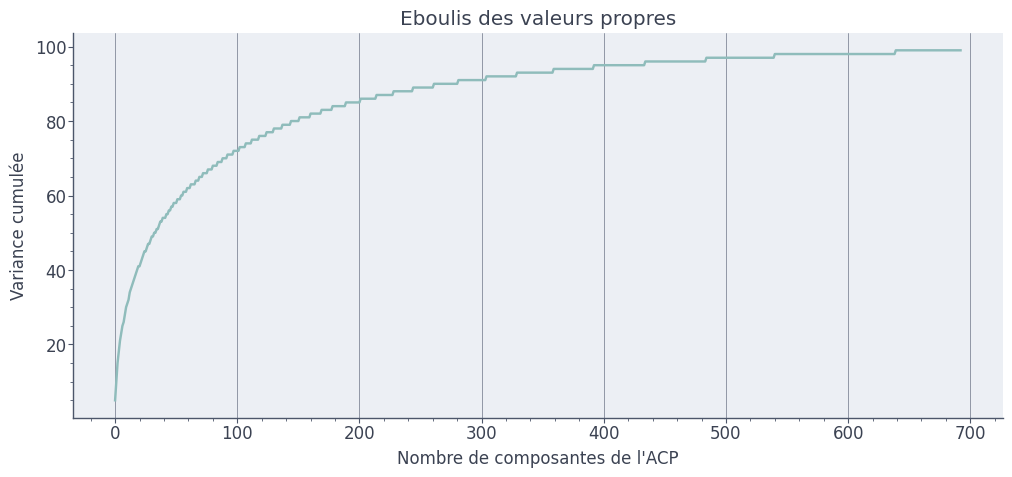

In [13]:
# Variance captée par chaque nouvelle composante
scree = (acp.explained_variance_ratio_ * 100).round(2)

# Variance retenue cumulée
scree_cum = scree.cumsum().round()

# Représentation graphique de la variance retenue cumulé
plt.figure(figsize=(12, 5))
plt.plot(range(len(scree)), scree_cum)
plt.xlabel("Nombre de composantes de l'ACP")
plt.ylabel("Variance cumulée")
plt.title("Eboulis des valeurs propres")
plt.grid(axis="y")
plt.show()

### Visualisation T-SNE


On va visualer nos données textuel en fonction des catégories compris dans 'product_category_tree'


#### Visualisation T-SNE en fonction des categories


/home/dimitri/anaconda3/envs/projet6_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


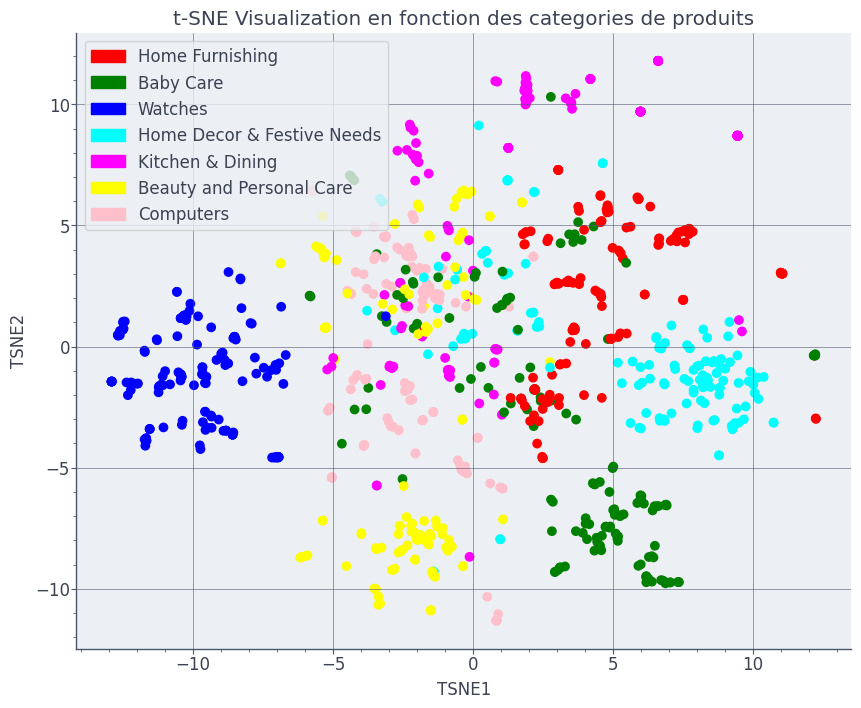

In [14]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_acp)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category"] = tsne_results[:, 0]
df_product_clean["TSNE2_category"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category"], df_product_clean["TSNE2_category"], c=color_list
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Vérification de la classification des données textuels avec K-means


#### Visualisation TSNE Kmeans clustering


In [15]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

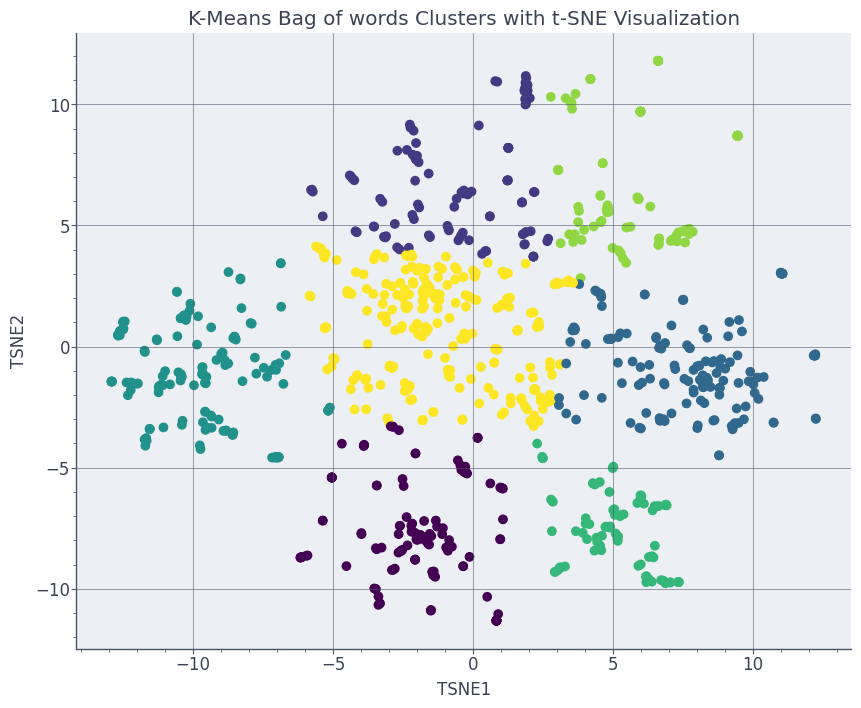

In [16]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["Cluster_bow_kmeans"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_bow_kmeans"] = tsne_results[:, 0]
df_product_clean["TSNE2_bow_kmeans"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_bow_kmeans"],
    df_product_clean["TSNE2_bow_kmeans"],
    c=df_product_clean["Cluster_bow_kmeans"],
)
plt.title("K-Means Bag of words Clusters with t-SNE Visualization")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [17]:
clusters_labels = kmeans.labels_

In [18]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec Bag of words : {ari}")

Adjusted Rand Index (ARI) avec Bag of words : 0.3347680212712181


## Extration des Features de textes : Approche TF-IDF


In [19]:
text_columns = ["product_name", "description"]
# Combine text in one columns from 'product_name' and 'description'
df_product_clean["product_name_description"] = df_product_clean[text_columns].agg(
    " ".join, axis=1
)
# Init le CountVectorizer
vectorizer_tfidf = TfidfVectorizer()

# Ajust vectoriser and transform text data
X_tfidf = vectorizer_tfidf.fit_transform(df_product_clean["product_name_description"])

# Get name of words (features)
features_tfidf = vectorizer_tfidf.get_feature_names_out()

# Convert matrix to Dataframe pandas
df_tfidf = pd.DataFrame(X.toarray(), columns=features_tfidf)

# Get result dataframe
display(df_tfidf)

,aa,aaa,aapno,aari,aarika,ability,abklgrngrngrn,abklplplpnk,abklplpnkpnk,able,...,zinc,zingalalaa,zip,zipexterior,zipper,zippered,zone,zoom,zora,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print("Taille: ", len(vectorizer_tfidf.vocabulary_))
print("Contenu:", vectorizer_tfidf.vocabulary_)

Taille:  5130
Contenu: {'elegance': 1454, 'polyester': 3437, 'multicolor': 2954, 'abstract': 19, 'eyelet': 1606, 'door': 1320, 'curtain': 1102, 'key': 2444, 'feature': 1663, 'floral': 1756, 'curtainelegance': 1103, 'cm': 831, 'height': 2103, 'pack': 3219, 'price': 3515, 'enhances': 1489, 'look': 2647, 'interiorsthis': 2330, 'made': 2706, 'high': 2122, 'quality': 3619, 'fabricit': 1615, 'style': 4409, 'stitch': 4360, 'metal': 2832, 'ringit': 3831, 'make': 2724, 'room': 3865, 'environment': 1513, 'romantic': 3861, 'lovingthis': 2672, 'ant': 180, 'wrinkle': 5072, 'anti': 184, 'shrinkage': 4116, 'elegant': 1455, 'apparancegive': 206, 'home': 2152, 'bright': 553, 'modernistic': 2892, 'appeal': 208, 'design': 1210, 'surreal': 4476, 'attention': 284, 'sure': 4467, 'steal': 4343, 'heart': 2095, 'contemporary': 972, 'valance': 4817, 'slide': 4188, 'smoothly': 4215, 'draw': 1332, 'apart': 201, 'first': 1717, 'thing': 4606, 'morning': 2915, 'welcome': 4976, 'sun': 4438, 'ray': 3674, 'want': 4930,

### Réduction des dimensions acp


In [21]:
txt_features = X_tfidf.todense()
print("Dimensions dataset avant réduction PCA : ", txt_features.shape)

Dimensions dataset avant réduction PCA :  (1050, 5130)


In [22]:
# Standisation of data
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(np.asarray(txt_features))

In [23]:
acp = PCA(n_components=0.99, random_state=42)
X_acp_tfidf = acp.fit_transform(np.asarray(txt_features))
print("Dimensions dataset après réduction acp : ", X_acp_tfidf.shape)

Dimensions dataset après réduction acp :  (1050, 839)


In [24]:
acp.explained_variance_ratio_
explained_variance_ratio = acp.explained_variance_ratio_

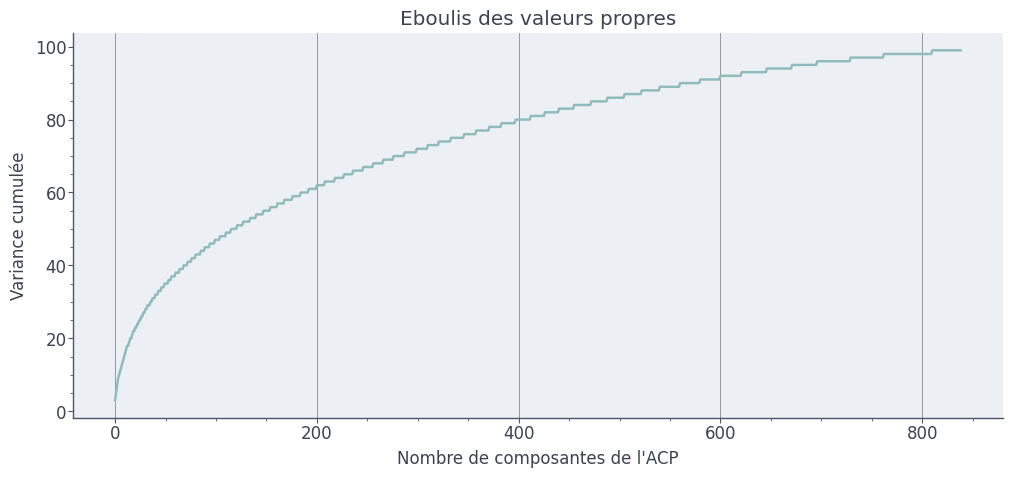

In [25]:
# Variance captée par chaque nouvelle composante
scree = (acp.explained_variance_ratio_ * 100).round(2)

# Variance retenue cumulée
scree_cum = scree.cumsum().round()

# Représentation graphique de la variance retenue cumulé
plt.figure(figsize=(12, 5))
plt.plot(range(len(scree)), scree_cum)
plt.xlabel("Nombre de composantes de l'ACP")
plt.ylabel("Variance cumulée")
plt.title("Eboulis des valeurs propres")
plt.grid(axis="y")
plt.show()

### Visualisation T-SNE


In [26]:
df_product_clean["first_category"].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

#### Visualisation T-SNE en fonction des categories


/home/dimitri/anaconda3/envs/projet6_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


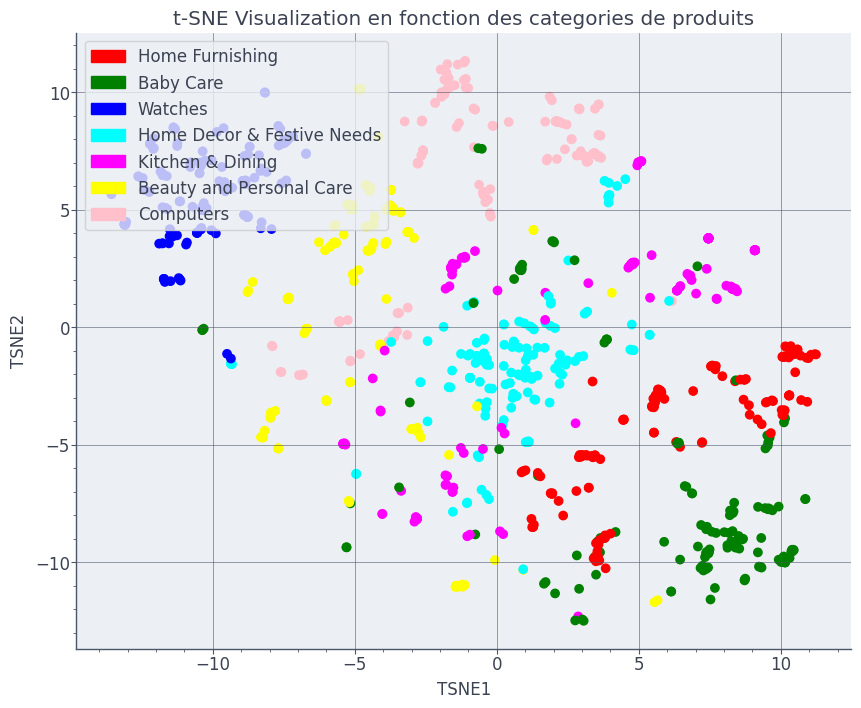

In [27]:
# Apply TSNE to data
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results = tsne.fit_transform(X_acp_tfidf)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category"] = tsne_results[:, 0]
df_product_clean["TSNE2_category"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category"], df_product_clean["TSNE2_category"], c=color_list
)
legend_handles = [
    mpatches.Patch(color=colors["Home Furnishing"], label="Home Furnishing"),
    mpatches.Patch(color=colors["Baby Care"], label="Baby Care"),
    mpatches.Patch(color=colors["Watches"], label="Watches"),
    mpatches.Patch(
        color=colors["Home Decor & Festive Needs"], label="Home Decor & Festive Needs"
    ),
    mpatches.Patch(color=colors["Kitchen & Dining"], label="Kitchen & Dining"),
    mpatches.Patch(
        color=colors["Beauty and Personal Care"], label="Beauty and Personal Care"
    ),
    mpatches.Patch(color=colors["Computers"], label="Computers"),
]
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization en fonction des categories de produits")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Vérification de la classification des données textuels avec K-means


#### Visualisation TSNE Kmeans clustering


In [28]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

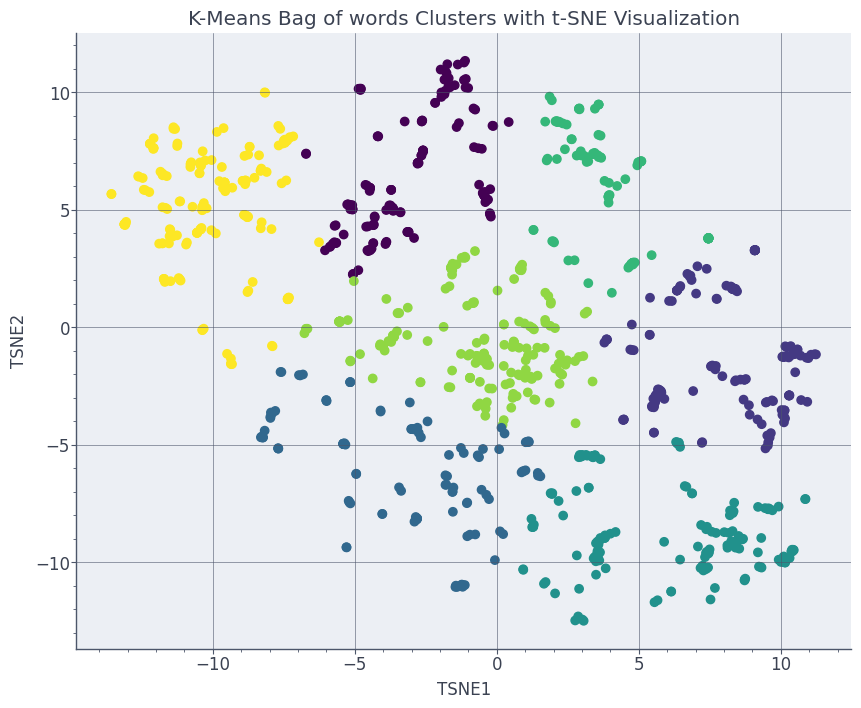

In [29]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["Cluster_tfidf"] = kmeans.fit_predict(tsne_results)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_tfidf"] = tsne_results[:, 0]
df_product_clean["TSNE2_tfidf"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_tfidf"],
    df_product_clean["TSNE2_tfidf"],
    c=df_product_clean["Cluster_tfidf"],
)
plt.title("K-Means Bag of words Clusters with t-SNE Visualization")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [30]:
clusters_labels = kmeans.labels_

In [31]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec TFIDF : {ari}")

Adjusted Rand Index (ARI) avec TFIDF : 0.40929538418594097


## Extration des Features de textes : Approche Word2vec


##### Creation d'une liste découper par mots


In [32]:
sentences = df_product_clean["product_name_description"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [33]:
display(sentences[0])

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtainelegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interiorsthis',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabricit',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ringit',
 'make',
 'room',
 'environment',
 'romantic',
 'lovingthis',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparancegive',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'wo

##### Entrainement du modèle


In [35]:
w2v_size = 300  #  Dimensionality of the word vectors.
w2v_window = (
    5  # Maximum distance between the current and predicted word within a sentence.
)
w2v_min_count = 1  # Ignores all words with total frequency lower than this.
w2v_epochs = 100  #  Number of iterations (epochs) over the corpus. (Formerly: iter)
maxlen = 100  # adapt to length of sentences

w2v_model = gensim.models.Word2Vec(
    min_count=w2v_min_count,
    window=w2v_window,
    vector_size=w2v_size,
    seed=42,  # Seed for the random number generator
    workers=1,
)  # Use these many worker threads to train the model (=faster training with multicore machines).
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 4943
Word2Vec trained


##### Visualisation T-SNE


#### Visualisation T-SNE en fonction des categories

/home/dimitri/anaconda3/envs/projet6_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


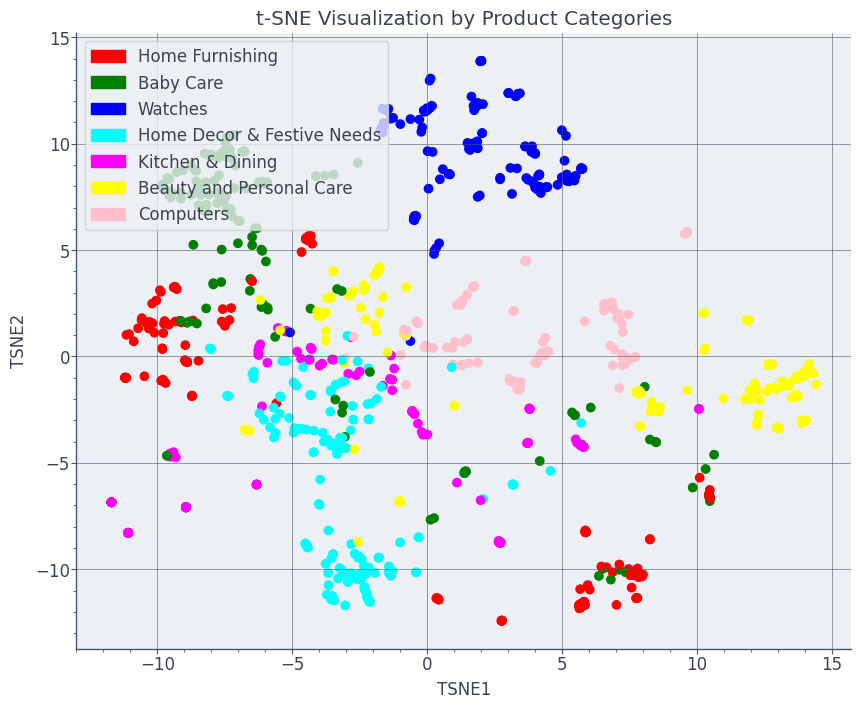

In [39]:
# Function to compute the average Word2Vec vector for a given description
def get_avg_word2vec_vector(description, model):
    words = description.split()  # Split the description into words
    vectors = [
        model.wv[word] for word in words if word in model.wv
    ]  # Retrieve vectors for known words
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Compute the average of the word vectors
    else:
        return np.zeros(w2v_size)  # If no known words, return a zero vector


# Apply the function to each product description
df_product_clean["avg_word2vec"] = df_product_clean["product_name_description"].apply(
    lambda x: get_avg_word2vec_vector(x, w2v_model)
)

# Convert the list of vectors into a NumPy matrix
product_vectors = np.vstack(df_product_clean["avg_word2vec"].values)

# Define colors for specific product categories
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]

# Apply t-SNE to the product vectors
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results_w2v = tsne.fit_transform(product_vectors)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_word2vec"] = tsne_results_w2v[:, 0]
df_product_clean["TSNE2_category_word2vec"] = tsne_results_w2v[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_word2vec"],
    df_product_clean["TSNE2_category_word2vec"],
    c=color_list,
)
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization by Product Categories")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Vérification de la classification des données textuels avec K-means


#### Visualisation TSNE Kmeans clustering


In [38]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

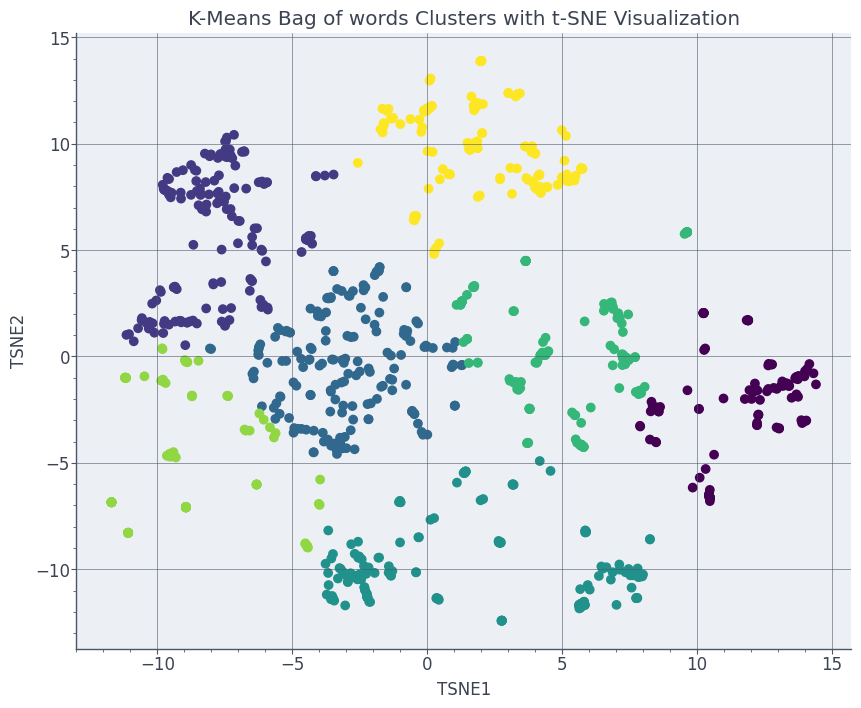

In [40]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["Cluster_w2v"] = kmeans.fit_predict(tsne_results_w2v)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_w2v"] = tsne_results[:, 0]
df_product_clean["TSNE2_w2v"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_w2v"],
    df_product_clean["TSNE2_w2v"],
    c=df_product_clean["Cluster_w2v"],
)
plt.title("K-Means Bag of words Clusters with t-SNE Visualization")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [41]:
clusters_labels = kmeans.labels_

In [42]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec Word2vec : {ari}")

Adjusted Rand Index (ARI) avec Word2vec : 0.4364174953607338


## Extration des Features de textes : Approche Bert

##### Creation d'une liste découper par mots


In [ ]:
sentences = df_product_clean["product_name_description"].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
display(sentences[0])

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtainelegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'height',
 'pack',
 'price',
 'curtain',
 'enhances',
 'look',
 'interiorsthis',
 'curtain',
 'made',
 'high',
 'quality',
 'polyester',
 'fabricit',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ringit',
 'make',
 'room',
 'environment',
 'romantic',
 'lovingthis',
 'curtain',
 'ant',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparancegive',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morning',
 'whole',
 'wo

##### Entrainement du modèle


In [ ]:
w2v_size = 300  #  Dimensionality of the word vectors.
w2v_window = (
    5  # Maximum distance between the current and predicted word within a sentence.
)
w2v_min_count = 1  # Ignores all words with total frequency lower than this.
w2v_epochs = 100  #  Number of iterations (epochs) over the corpus. (Formerly: iter)
maxlen = 100  # adapt to length of sentences

w2v_model = gensim.models.Word2Vec(
    min_count=w2v_min_count,
    window=w2v_window,
    vector_size=w2v_size,
    seed=42,  # Seed for the random number generator
    workers=1,
)  # Use these many worker threads to train the model (=faster training with multicore machines).
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Vocabulary size: 4943
Word2Vec trained


##### Visualisation T-SNE


#### Visualisation T-SNE en fonction des categories

/home/dimitri/anaconda3/envs/projet6_env/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


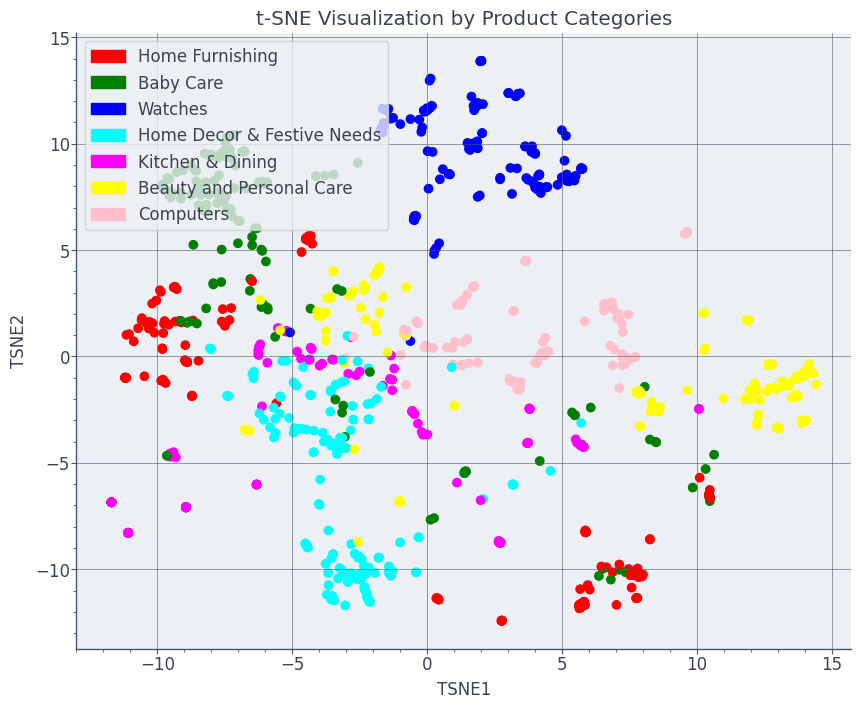

In [ ]:
# Function to compute the average Word2Vec vector for a given description
def get_avg_word2vec_vector(description, model):
    words = description.split()  # Split the description into words
    vectors = [
        model.wv[word] for word in words if word in model.wv
    ]  # Retrieve vectors for known words
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Compute the average of the word vectors
    else:
        return np.zeros(w2v_size)  # If no known words, return a zero vector


# Apply the function to each product description
df_product_clean["avg_word2vec"] = df_product_clean["product_name_description"].apply(
    lambda x: get_avg_word2vec_vector(x, w2v_model)
)

# Convert the list of vectors into a NumPy matrix
product_vectors = np.vstack(df_product_clean["avg_word2vec"].values)

# Define colors for specific product categories
colors = {
    "Home Furnishing": "red",
    "Baby Care": "green",
    "Watches": "blue",
    "Home Decor & Festive Needs": "cyan",
    "Kitchen & Dining": "magenta",
    "Beauty and Personal Care": "yellow",
    "Computers": "pink",
}
color_list = [colors[group] for group in df_product_clean["first_category"]]

# Apply t-SNE to the product vectors
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_results_w2v = tsne.fit_transform(product_vectors)

# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_category_word2vec"] = tsne_results_w2v[:, 0]
df_product_clean["TSNE2_category_word2vec"] = tsne_results_w2v[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_category_word2vec"],
    df_product_clean["TSNE2_category_word2vec"],
    c=color_list,
)
plt.legend(handles=legend_handles, loc="upper left")
plt.title("t-SNE Visualization by Product Categories")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Vérification de la classification des données textuels avec K-means


#### Visualisation TSNE Kmeans clustering


In [ ]:
main_categ_list = df_product_clean["first_category"].unique().tolist()

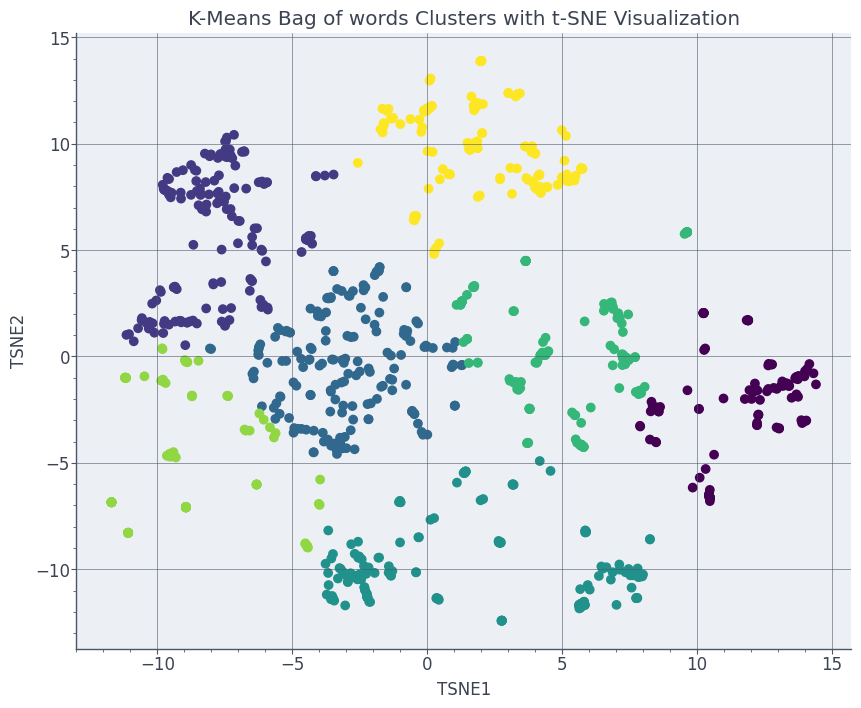

In [ ]:
# Apply K-Means clustering

kmeans = KMeans(n_clusters=len(main_categ_list), random_state=42)
df_product_clean["Cluster_w2v"] = kmeans.fit_predict(tsne_results_w2v)


# Add t-SNE results to the DataFrame
df_product_clean["TSNE1_w2v"] = tsne_results[:, 0]
df_product_clean["TSNE2_w2v"] = tsne_results[:, 1]

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(
    df_product_clean["TSNE1_w2v"],
    df_product_clean["TSNE2_w2v"],
    c=df_product_clean["Cluster_w2v"],
)
plt.title("K-Means Bag of words Clusters with t-SNE Visualization")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

#### Comparaison catégorie réelle/clustering K-means (ARI score)


In [ ]:
clusters_labels = kmeans.labels_

In [ ]:
ari = adjusted_rand_score(df_product_clean["first_category"], clusters_labels)
print(f"Adjusted Rand Index (ARI) avec Word2vec : {ari}")

Adjusted Rand Index (ARI) avec Word2vec : 0.4364174953607338
